In [25]:
import os
import pandas as pd
from neuralprophet import NeuralProphet
from dotenv import load_dotenv
import dropbox
import requests
from utils import upload
from neuralprophet import set_random_seed


load_dotenv()

# Function to reformat the forecast data


def reformat_forecast(forecast):
    forecast_data = []

    for i in range(8):
        step_col = f"step{i}"
        quantile_20_col = f"step{i} 20.0%"  # Column name for 20th percentile
        quantile_80_col = f"step{i} 80.0%"  # Column name for 80th percentile

        forecast_data.append({
            "ds": forecast["ds"].iloc[0] + pd.Timedelta(hours=i),
            "yhat": forecast[step_col].iloc[0],
            # Add lower bound (20th percentile)
            "yhat_lower": forecast[quantile_20_col].iloc[0],
            # Add upper bound (80th percentile)
            "yhat_upper": forecast[quantile_80_col].iloc[0]
        })

    new_forecast_df = pd.DataFrame(forecast_data)
    return new_forecast_df


data = pd.read_csv(
    'https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1')
data.ds = pd.to_datetime(data.ds)
data = data.sort_values('ds')



In [2]:
data.columns

Index(['ds', 'INFLOW_STRETCHER', 'Infl_Stretcher_cum', 'INFLOW_AMBULATORY',
       'Infl_Ambulatory_cum', 'Inflow_Total', 'Inflow_Cum_Total',
       'INFLOW_AMBULANCES', 'Infl_Ambulances_cum', 'FLS', 'CUM_ADMREQ',
       'CUM_BA1', 'WAITINGADM', 'TTStr', 'TRG_HALLWAY1', 'TRG_HALLWAY_TBS',
       'reoriented_cum', 'reoriented_cum_MD', 'QTRACK1', 'RESUS', 'Pod_T',
       'POD_GREEN', 'POD_GREEN_TBS', 'POD_YELLOW', 'POD_YELLOW_TBS',
       'POD_ORANGE', 'POD_ORANGE_TBS', 'POD_CONS_MORE2H', 'POD_IMCONS_MORE4H',
       'POD_XRAY_MORE2H', 'POD_CT_MORE2H', 'POST_POD1', 'VERTSTRET', 'RAZ_TBS',
       'RAZ_LAZYBOY', 'RAZ_WAITINGREZ', 'AMBVERT1', 'AMBVERTTBS', 'QTrack_TBS',
       'Garage_TBS', 'RAZ_CONS_MORE2H', 'RAZ_IMCONS_MORE4H', 'RAZ_XRAY_MORE2H',
       'RAZ_CT_MORE2H1', 'PSYCH1', 'PSYCH_WAITINGADM'],
      dtype='object')

In [3]:
df = data.copy()
df = df[['ds', 'Inflow_Total']].rename(columns={'ds': 'ds', 'Inflow_Total': 'y'})
df

,ds,y
0,2021-01-01 01:00:00,2
1,2021-01-01 02:00:00,3
2,2021-01-01 03:00:00,1
3,2021-01-01 04:00:00,1
4,2021-01-01 05:00:00,2
...,...,...
36110,2025-02-16 08:00:00,4
36111,2025-02-16 09:00:00,11
36112,2025-02-16 10:00:00,16
36113,2025-02-16 11:00:00,15


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.892% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/env

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 29. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.580388,0.0,9.266832,11.738195,0.579168,0.0,0
1,0.095760,0.0,3.421455,4.475809,0.095712,0.0,1
2,0.065618,0.0,2.839949,3.741411,0.065592,0.0,2
3,0.056101,0.0,2.606123,3.474591,0.056104,0.0,3
4,0.054273,0.0,2.555099,3.421160,0.054265,0.0,4
5,0.053399,0.0,2.543157,3.408309,0.053436,0.0,5
6,0.053108,0.0,2.537868,3.403078,0.053118,0.0,6
7,0.053001,0.0,2.534250,3.398821,0.052997,0.0,7
8,0.052821,0.0,2.527260,3.391356,0.052806,0.0,8
9,0.052668,0.0,2.522038,3.385917,0.052650,0.0,9


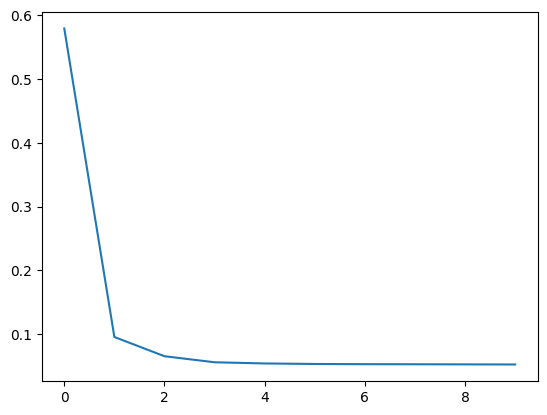

In [4]:
params = {
    'growth': 'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs': 10,
    'quantiles': [0.2, 0.5, 0.8]
}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
metrics = m.fit(df[['ds', 'y']], freq='h', progress='plot')
metrics

In [7]:
df_future = m.make_future_dataframe(df[['ds', 'y']], periods=8)
# df_future
forecast = m.predict(df_future, decompose=False, raw=True)

output_df = reformat_forecast(forecast)

print(output_df)

inflow_total_np = output_df.copy()

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.892% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and w

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


                   ds       yhat  yhat_lower  yhat_upper
0 2025-02-16 13:00:00  13.339988   12.269695   16.527895
1 2025-02-16 14:00:00  13.065852   11.999905   16.213310
2 2025-02-16 15:00:00  13.616680   11.298439   15.325239
3 2025-02-16 16:00:00  13.433803   10.468152   14.471891
4 2025-02-16 17:00:00  11.856752    9.806807   13.887588
5 2025-02-16 18:00:00   9.624932    8.878727   12.389217
6 2025-02-16 19:00:00   9.122805    8.303985   11.705740
7 2025-02-16 20:00:00   9.641809    7.485265   10.683016


In [11]:
data['y'] = data['POD_GREEN_TBS']+data['POD_YELLOW_TBS']+data['POD_ORANGE_TBS'] + \
    data['TRG_HALLWAY_TBS']+data['RAZ_TBS'] + \
    data['AMBVERTTBS']+data['QTrack_TBS']+data['Garage_TBS']
df = data.copy()
df = df[['ds', 'y', 'Inflow_Total']]
df

,ds,y,Inflow_Total
0,2021-01-01 01:00:00,0.0,2
1,2021-01-01 02:00:00,3.0,3
2,2021-01-01 03:00:00,2.0,1
3,2021-01-01 04:00:00,1.0,1
4,2021-01-01 05:00:00,2.0,2
...,...,...,...
36110,2025-02-16 08:00:00,9.0,4
36111,2025-02-16 09:00:00,11.0,11
36112,2025-02-16 10:00:00,17.0,16
36113,2025-02-16 11:00:00,23.0,15


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.892% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/env

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,1.355411,0.0,29.922907,37.976658,1.353078,0.0,0
1,0.350946,0.0,11.062915,14.026287,0.350674,0.0,1
2,0.219019,0.0,8.959414,11.399084,0.218960,0.0,2
3,0.165444,0.0,7.855343,10.022122,0.165388,0.0,3
4,0.128263,0.0,6.960080,8.935855,0.128158,0.0,4
5,0.103607,0.0,6.330407,8.180874,0.103552,0.0,5
6,0.089316,0.0,5.966761,7.754884,0.089304,0.0,6
7,0.079300,0.0,5.742147,7.490252,0.079260,0.0,7
8,0.074541,0.0,5.653267,7.391137,0.074547,0.0,8
9,0.069135,0.0,5.537042,7.256420,0.069096,0.0,9


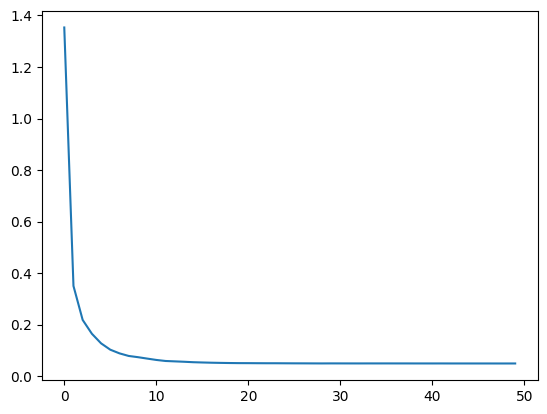

In [13]:



params = {
    'growth': 'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs': 50,
    'quantiles': [0.2, 0.5, 0.8]
}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
m.add_future_regressor('Inflow_Total')
metrics = m.fit(df, freq='h', progress='plot')
metrics


In [18]:
inflow_total_np['yhat'].tolist()

[13.339987754821777,
 13.065852165222168,
 13.616680145263672,
 13.433802604675293,
 11.856752395629883,
 9.624932289123535,
 9.122804641723633,
 9.641809463500977]

In [20]:
df_future = m.make_future_dataframe(df[['ds', 'y', 'Inflow_Total']], periods=8, regressors_df=inflow_total_np[['ds', 'yhat']].rename(columns={'ds': 'ds', 'yhat': 'Inflow_Total'}))
df_future



WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.892% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and w

,ds,y,Inflow_Total
0,2025-02-14 13:00:00,23.0,16.000000
1,2025-02-14 14:00:00,21.0,14.000000
2,2025-02-14 15:00:00,16.0,13.000000
3,2025-02-14 16:00:00,27.0,20.000000
4,2025-02-14 17:00:00,25.0,18.000000
5,2025-02-14 18:00:00,28.0,16.000000
6,2025-02-14 19:00:00,28.0,8.000000
7,2025-02-14 20:00:00,17.0,10.000000
8,2025-02-14 21:00:00,22.0,15.000000
9,2025-02-14 22:00:00,17.0,3.000000


In [21]:
forecast = m.predict(df_future, decompose=False, raw=True)

output_df = reformat_forecast(forecast)

print(output_df)

WARNING - (NP.forecaster.predict) - Raw forecasts are incompatible with plotting utilities
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 98.214% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - h
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 98.214% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/si

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


                   ds       yhat  yhat_lower  yhat_upper
0 2025-02-16 13:00:00  28.369638   24.398548   31.208130
1 2025-02-16 14:00:00  30.185778   25.469288   33.456734
2 2025-02-16 15:00:00  32.264935   27.777592   36.290344
3 2025-02-16 16:00:00  37.180622   32.796967   41.872746
4 2025-02-16 17:00:00  32.709694   28.485516   36.569046
5 2025-02-16 18:00:00  29.172161   24.850801   32.645462
6 2025-02-16 19:00:00  29.032551   24.924826   32.934666
7 2025-02-16 20:00:00  26.019430   22.243870   30.044575


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.892% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/env

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.521090,0.0,19.026396,24.678047,0.520060,0.0,0
1,0.122549,0.0,7.934872,10.119216,0.122455,0.0,1
2,0.093300,0.0,7.107813,9.119860,0.093299,0.0,2
3,0.079814,0.0,6.546317,8.448478,0.079834,0.0,3
4,0.068959,0.0,5.984442,7.757930,0.068961,0.0,4
5,0.061416,0.0,5.522609,7.183821,0.061555,0.0,5
6,0.058159,0.0,5.310674,6.919458,0.058162,0.0,6
7,0.057567,0.0,5.262703,6.865952,0.057502,0.0,7
8,0.057778,0.0,5.257648,6.864373,0.057788,0.0,8
9,0.058491,0.0,5.271452,6.878527,0.058491,0.0,9


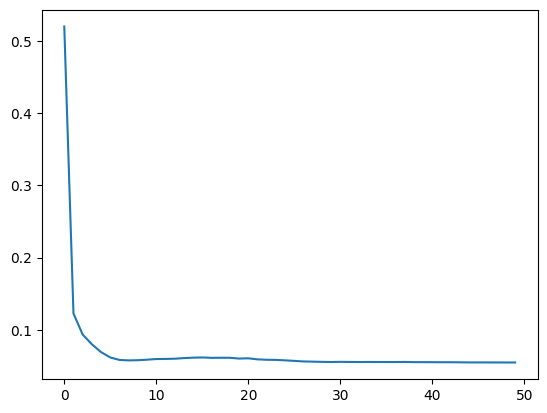

In [ ]:


params = {
    'growth': 'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs': 50,
    'quantiles': [0.2, 0.5, 0.8]
}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
set_random_seed(42)
metrics = m.fit(df[['ds','y']], freq='h', progress='plot')
metrics


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.892% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/env

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.441974,0.0,13.305729,16.925879,0.441224,0.0,0
1,0.105199,0.0,7.029193,8.973993,0.105121,0.0,1
2,0.081005,0.0,6.211591,7.967942,0.081019,0.0,2
3,0.072176,0.0,5.856099,7.543909,0.072137,0.0,3
4,0.067487,0.0,5.653576,7.322231,0.067442,0.0,4
5,0.064624,0.0,5.525620,7.186617,0.064679,0.0,5
6,0.061460,0.0,5.415014,7.055649,0.061480,0.0,6
7,0.059371,0.0,5.323199,6.948888,0.059361,0.0,7
8,0.057834,0.0,5.253795,6.859401,0.057774,0.0,8
9,0.057937,0.0,5.267960,6.870677,0.057963,0.0,9


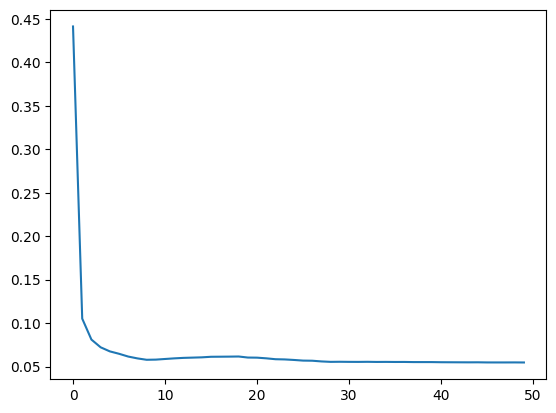

In [26]:


params = {
    'growth': 'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs': 50,
    'quantiles': [0.2, 0.5, 0.8]
}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
m.add_country_holidays('CA')
set_random_seed(42)
metrics = m.fit(df[['ds','y']], freq='h', progress='plot')
metrics


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.


WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.892% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and w

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,1.230362,0.0,37.354599,47.859852,1.228393,0.0,0
1,0.332532,0.0,14.110638,17.833368,0.332134,0.0,1
2,0.159060,0.0,8.915393,11.313983,0.158894,0.0,2
3,0.111520,0.0,7.432354,9.466427,0.111475,0.0,3
4,0.091341,0.0,6.711854,8.568461,0.091282,0.0,4
5,0.082050,0.0,6.320408,8.091458,0.082023,0.0,5
6,0.076062,0.0,6.090434,7.819905,0.076033,0.0,6
7,0.071543,0.0,5.912328,7.614783,0.071616,0.0,7
8,0.068376,0.0,5.776272,7.456898,0.068360,0.0,8
9,0.066333,0.0,5.678080,7.346851,0.066303,0.0,9


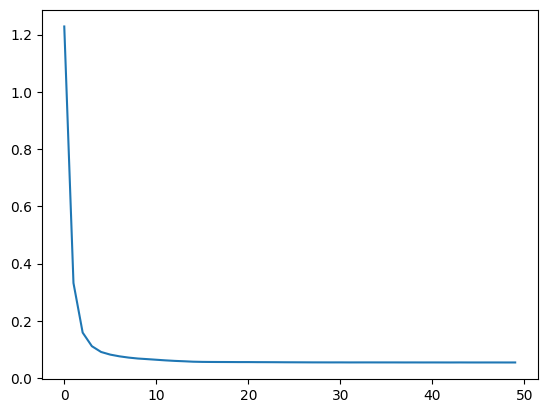

In [27]:


params = {
    'growth': 'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs': 50,
    'quantiles': [0.2, 0.5, 0.8]
}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
m.add_country_holidays({'CA':'QC'})
metrics = m.fit(df[['ds','y']], freq='h', progress='plot')
metrics


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.892% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/env

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.512365,0.0,17.896175,22.667978,0.511384,0.0,0
1,0.116927,0.0,7.661076,9.816773,0.116891,0.0,1
2,0.093487,0.0,6.883986,8.870603,0.093445,0.0,2
3,0.080678,0.0,6.373908,8.226297,0.080674,0.0,3
4,0.071233,0.0,5.972574,7.717387,0.071264,0.0,4
5,0.062884,0.0,5.542496,7.181951,0.062898,0.0,5
6,0.059232,0.0,5.354686,6.965041,0.059183,0.0,6
7,0.058124,0.0,5.294304,6.899932,0.058137,0.0,7
8,0.057639,0.0,5.265073,6.865342,0.057644,0.0,8
9,0.057724,0.0,5.252936,6.852314,0.057666,0.0,9


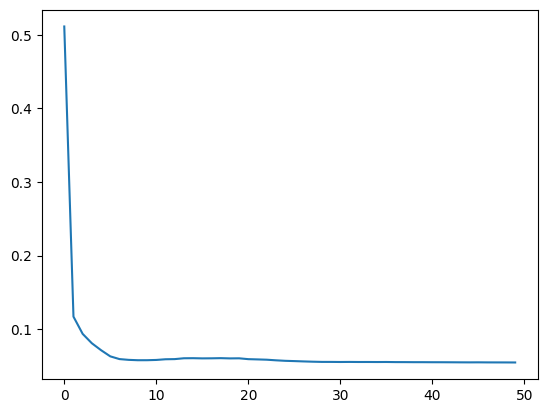

In [28]:


params = {
    'growth': 'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs': 50,
    'quantiles': [0.2, 0.5, 0.8]
}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
m.add_country_holidays('IL')
metrics = m.fit(df[['ds','y']], freq='h', progress='plot')
metrics


WARNING - (NP.forecaster.add_country_holidays) - Country holidays can only be added for a single country. Previous country holidays were overridden.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.892% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/ed-flow-2023/lib/python3.10/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dt

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/263 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.674629,0.0,16.620884,21.389317,0.673276,0.0,0
1,0.147401,0.0,7.322431,9.432484,0.147393,0.0,1
2,0.110045,0.0,6.651716,8.584198,0.110001,0.0,2
3,0.092464,0.0,6.331186,8.191056,0.092424,0.0,3
4,0.082103,0.0,6.128389,7.949938,0.082110,0.0,4
5,0.077455,0.0,6.019640,7.829082,0.077451,0.0,5
6,0.071802,0.0,5.893635,7.670169,0.071796,0.0,6
7,0.066516,0.0,5.680181,7.393251,0.066508,0.0,7
8,0.061479,0.0,5.402943,7.036684,0.061423,0.0,8
9,0.059484,0.0,5.342557,6.971265,0.059476,0.0,9


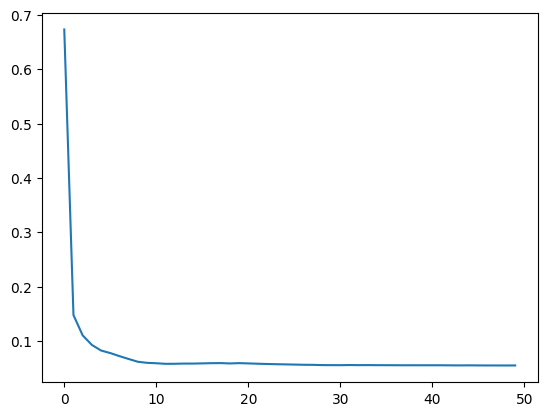

In [29]:


params = {
    'growth': 'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs': 50,
    'quantiles': [0.2, 0.5, 0.8]
}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
m.add_country_holidays({'CA':'QC'})
m.add_country_holidays('IL')
metrics = m.fit(df[['ds','y']], freq='h', progress='plot')
metrics
